In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib as mpl
from matplotlib import rcParams
rcParams["font.size"] = 13

In [2]:
# from netCDF4 import Dataset
# import os
# folder = r'C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\PEARL FTIR O3'
# files = glob.glob(folder + r'\*.hdf')
# output_folder = os.path.join(folder, 'netcdf_out')
# os.makedirs(output_folder, exist_ok=True)


# for file in files:
#     with Dataset(file, "r") as f:
#         output_file = os.path.basename(file) + ".nc"
#         cdf_file = os.path.join(output_folder, output_file)
#         with Dataset(cdf_file, "w", format="NETCDF4") as dst:
#             for attr in f.ncattrs():
#                 dst.setncattr(attr, f.getncattr(attr))

#             idx_len = int(str(list(f.dimensions.values())[0]).split()[-1])
#             dst.createDimension("altitude2", 47)
#             dst.createDimension("altitude1", 47)
#             dst.createDimension("single", 1)
#             dst.createDimension("source", 103)
#             dst.createDimension("two", 2)
#             dst.createDimension("idx", idx_len)
#             dst.createDimension("DATETIME", idx_len)

#             altitude1_var = dst.createVariable("altitude1", "i4", ("altitude1",))
#             altitude1_var[:] = f["ALTITUDE"][:]

#             vars = list(f.variables)
#             for var in vars:
#                 cdf_dims = []
#                 dims = f[var].dimensions
#                 if len(dims) > 2:
#                     cdf_dims.append("idx")
#                     cdf_dims.append("altitude1")
#                     cdf_dims.append("altitude2")
#                 else:
#                     for dim in dims:
#                         dim_len = len(f.dimensions[dim])
#                         if dim_len == idx_len:        
#                             cdf_dims.append("idx")
#                         elif dim_len == 2:
#                             cdf_dims.append("two")
#                         elif dim_len == 1:
#                             cdf_dims.append("single")
#                         elif dim_len == 103:
#                             cdf_dims.append("source")
#                         else:
#                             cdf_dims.append("altitude1")
#                 cdf_var = dst.createVariable(var, f[var].datatype, tuple(cdf_dims))
#                 for attr in f[var].ncattrs():
#                     if attr == "_FillValue":
#                         continue
#                     cdf_var.setncattr(attr, f[var].getncattr(attr))
#                 cdf_var[:] = f[var][:]

#             dst["DATETIME"].setncattr("units", "days since 2000-01-01 00:00:00")
#             dst["DATETIME"].setncattr("standard_name", "time")
#             dst["DATETIME"].setncattr("calendar", "standard")

In [3]:
from file_paths import PARENT_FOLDER
directory = PARENT_FOLDER + r'\PEARL_FTIR\netcdf_out'

path = directory + r'\*.nc'

nc_list = glob.glob(path)

f = xr.open_mfdataset(
    nc_list,
    combine="nested",
    concat_dim="idx",
    engine="netcdf4",
    decode_cf=True
)

In [4]:
O3_vmr = f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR"] * 1e-6
latitude = 80.05
longitude = -86.42
altitude = O3_vmr["altitude1"]

In [5]:
f = f.swap_dims({"idx": "DATETIME"})
f = f.sortby("DATETIME")

In [6]:
midpoints = np.mean(f["ALTITUDE.BOUNDARIES"][0].values, axis=0)
f = f.assign_coords(altitude1=('altitude1', midpoints))
f = f.sortby("altitude1")
alts = f["altitude1"].values
DATETIME = f["DATETIME"]
days_of_year = pd.to_datetime(DATETIME).dayofyear

In [7]:
vmr_apriori = f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR_APRIORI"].values
OG_AVKS = np.flip(f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR_AVK"].values, axis = 2)
AVKS = np.empty(OG_AVKS.shape)
for i in range(OG_AVKS.shape[0]):
    og_avk_measurement = OG_AVKS[i]
    apriori_measurement = np.tile(vmr_apriori[i], (47, 1))

    avk_row = og_avk_measurement * (apriori_measurement / apriori_measurement.T)
    
    AVKS[i,:,:] = avk_row

In [8]:
sensitivities = np.nansum(AVKS, axis=2)
sensitivities_mask = sensitivities >= 0.1
fraction_w_sensitivity = np.nansum(sensitivities_mask, axis = 0)/sensitivities_mask.shape[0]
upper_alt_idx = max(np.where(fraction_w_sensitivity >= 0.945)[0])
upper_alt_bound = alts[upper_alt_idx]

In [9]:
print(alts[36])
print(alts[38])

43.190002
50.699997


In [10]:

appropriate_AVKS = AVKS[days_of_year.isin([i for i in range(57,79)] + [i for i in range(262, 292)])] # 57 to 78, 262 to 291 is where satellites have coincidence over the the north
appropriate_sensitivities = np.nansum(AVKS, axis=2)
appropriate_sensitivities_mask = appropriate_sensitivities >= 0.5
appropriate_fraction_w_sensitivity = np.nansum(appropriate_sensitivities_mask, axis = 0)/appropriate_sensitivities_mask.shape[0]
appropriate_upper_alt_idx = max(np.where(appropriate_fraction_w_sensitivity >= 0.95)[0])
appropriate_upper_alt_bound = alts[appropriate_upper_alt_idx]
appropriate_upper_alt_bound

np.float32(26.939999)

In [11]:
np.nansum(np.nanmean(appropriate_AVKS, axis = 0), axis = 1)[35]

np.float64(0.5030193703978645)

In [12]:
np.nansum(np.nanmean(appropriate_AVKS, axis = 0), axis = 1)[37]

np.float64(0.19710547974902992)

In [13]:
print(alts[35])
print(alts[37])

40.17
46.68


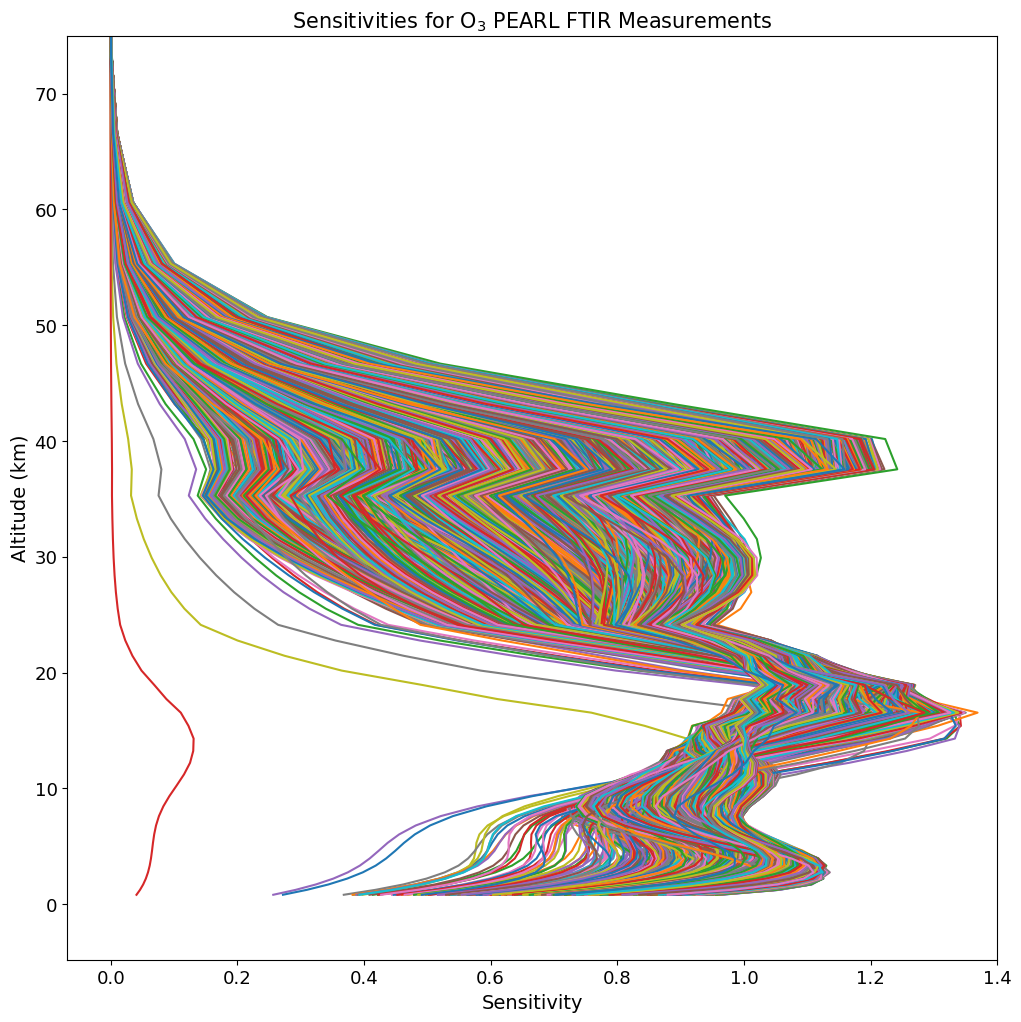

In [14]:
plt.figure(figsize=(12, 12))
plt.plot(sensitivities.T, alts)
plt.ylim(top = 75)
plt.xlabel("Sensitivity", fontsize = 14)
plt.ylabel("Altitude (km)", fontsize = 14)
plt.title("Sensitivities for O$_3$ PEARL FTIR Measurements", fontsize = 15)

fig = plt.gcf()
axes = plt.gca()
axes.set_xlim(right = 1.4)
title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

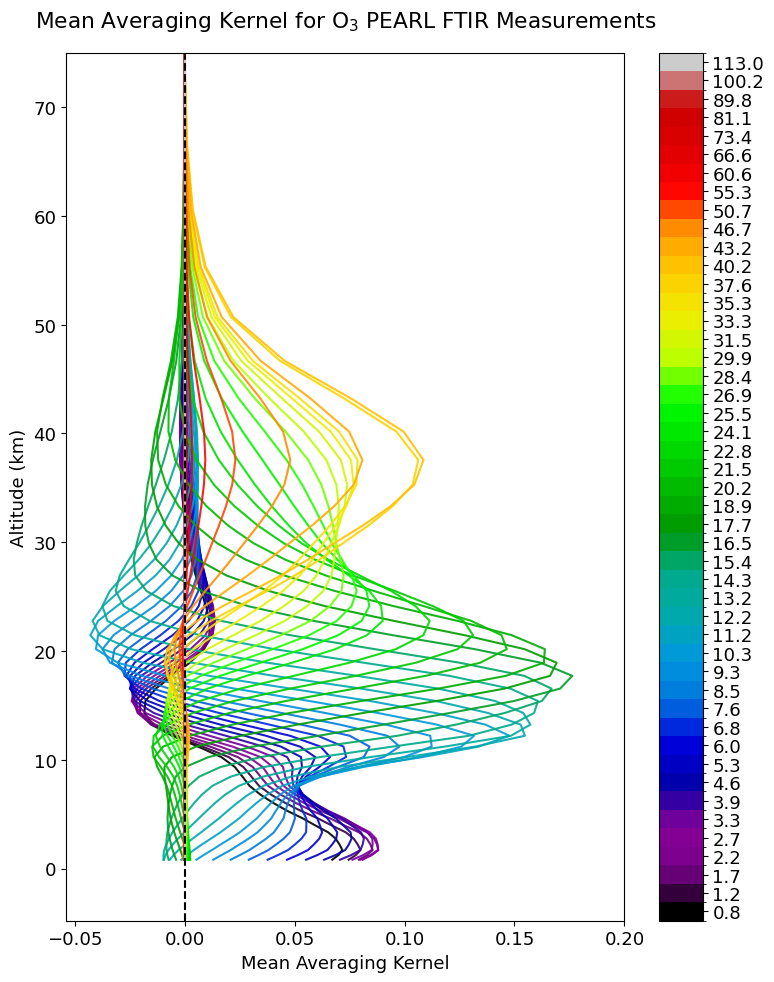

In [15]:
mean_avk = np.nanmean(AVKS, axis = 0)
alts     = f["altitude1"].values

fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("nipy_spectral", 47)
colors = cmap(np.arange(47))

for i in range(mean_avk.shape[0]):
    plt.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

cbar = fig.colorbar(sm, ax=ax,
                    boundaries=bounds,
                    ticks=alts,
                    spacing='uniform')

ymin, ymax = plt.ylim()
plt.plot([0, 0], [ymin, ymax], color='black', ls='dashed')
plt.ylim(ymin, 75)
ax.set_xlabel("Mean Averaging Kernel")
ax.set_ylabel("Altitude (km)")
ax.set_title("Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 1.02)
fig.tight_layout()
ax.set_xlim(right = 0.2)

title = ax.get_title()
fig.savefig(title, bbox_inches="tight")

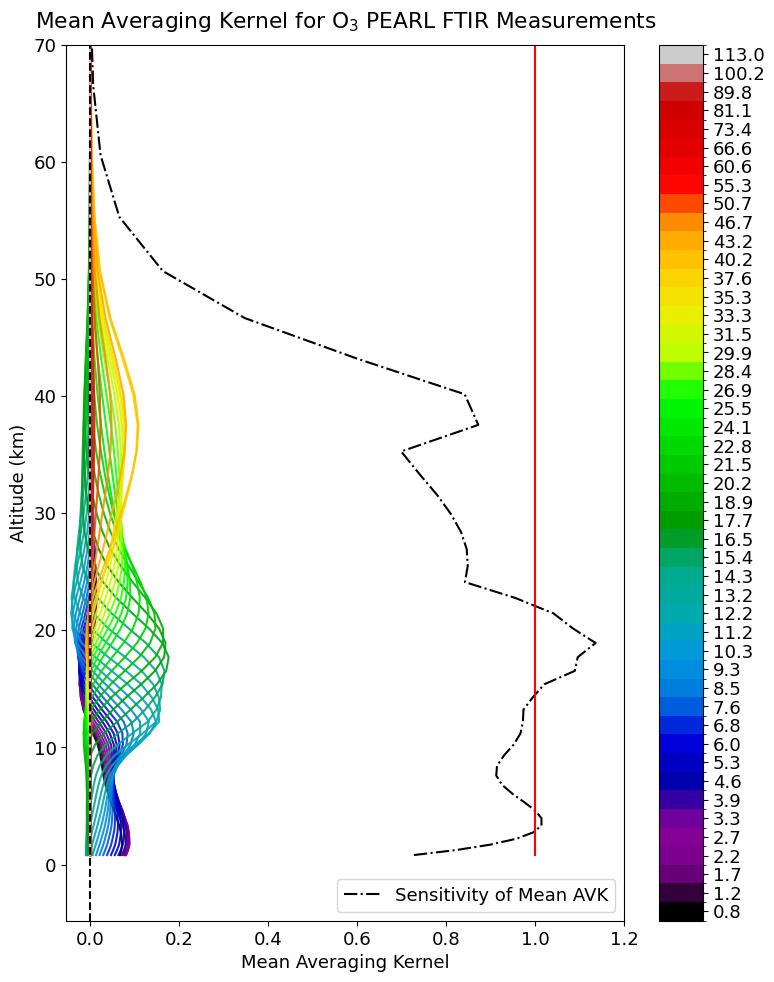

In [16]:
mean_avk = np.nanmean(AVKS, axis = 0)
alts     = f["altitude1"].values

fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("nipy_spectral", 47)
colors = cmap(np.arange(47))

for i in range(mean_avk.shape[0]):
    plt.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

cbar = fig.colorbar(sm, ax=ax,
                    boundaries=bounds,
                    ticks=alts,
                    spacing='uniform')          

ymin, ymax = plt.ylim()
plt.plot([0, 0], [ymin, ymax], color='black', ls='dashed')
plt.ylim(ymin, 70)
ax.set_xlim(right = 1.2)

plt.plot(np.nansum(mean_avk, axis = 1), alts, color='black', ls='-.', label = "Sensitivity of Mean AVK")
plt.legend()

ax.set_xlabel("Mean Averaging Kernel")
ax.set_ylabel("Altitude (km)")
ax.set_title("Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 1.01)
ax.plot([1] * len(alts), alts, color='red', ls='-')
ax.legend()
fig.tight_layout()

title = ax.get_title()
fig.savefig(title + "(with sensitivity)", bbox_inches="tight")

In [17]:
import pandas as pd
seasonal_months = {"DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11]}

pd_measurement_times = pd.to_datetime(DATETIME.values)
seasonal_measurement_idx = {season: np.where(pd_measurement_times.month.isin(months))[0]
                            for season, months in seasonal_months.items()}

seasonal_AVKS = {season: AVKS[seasonal_measurement_idx[season], :]
                 for season in seasonal_months}

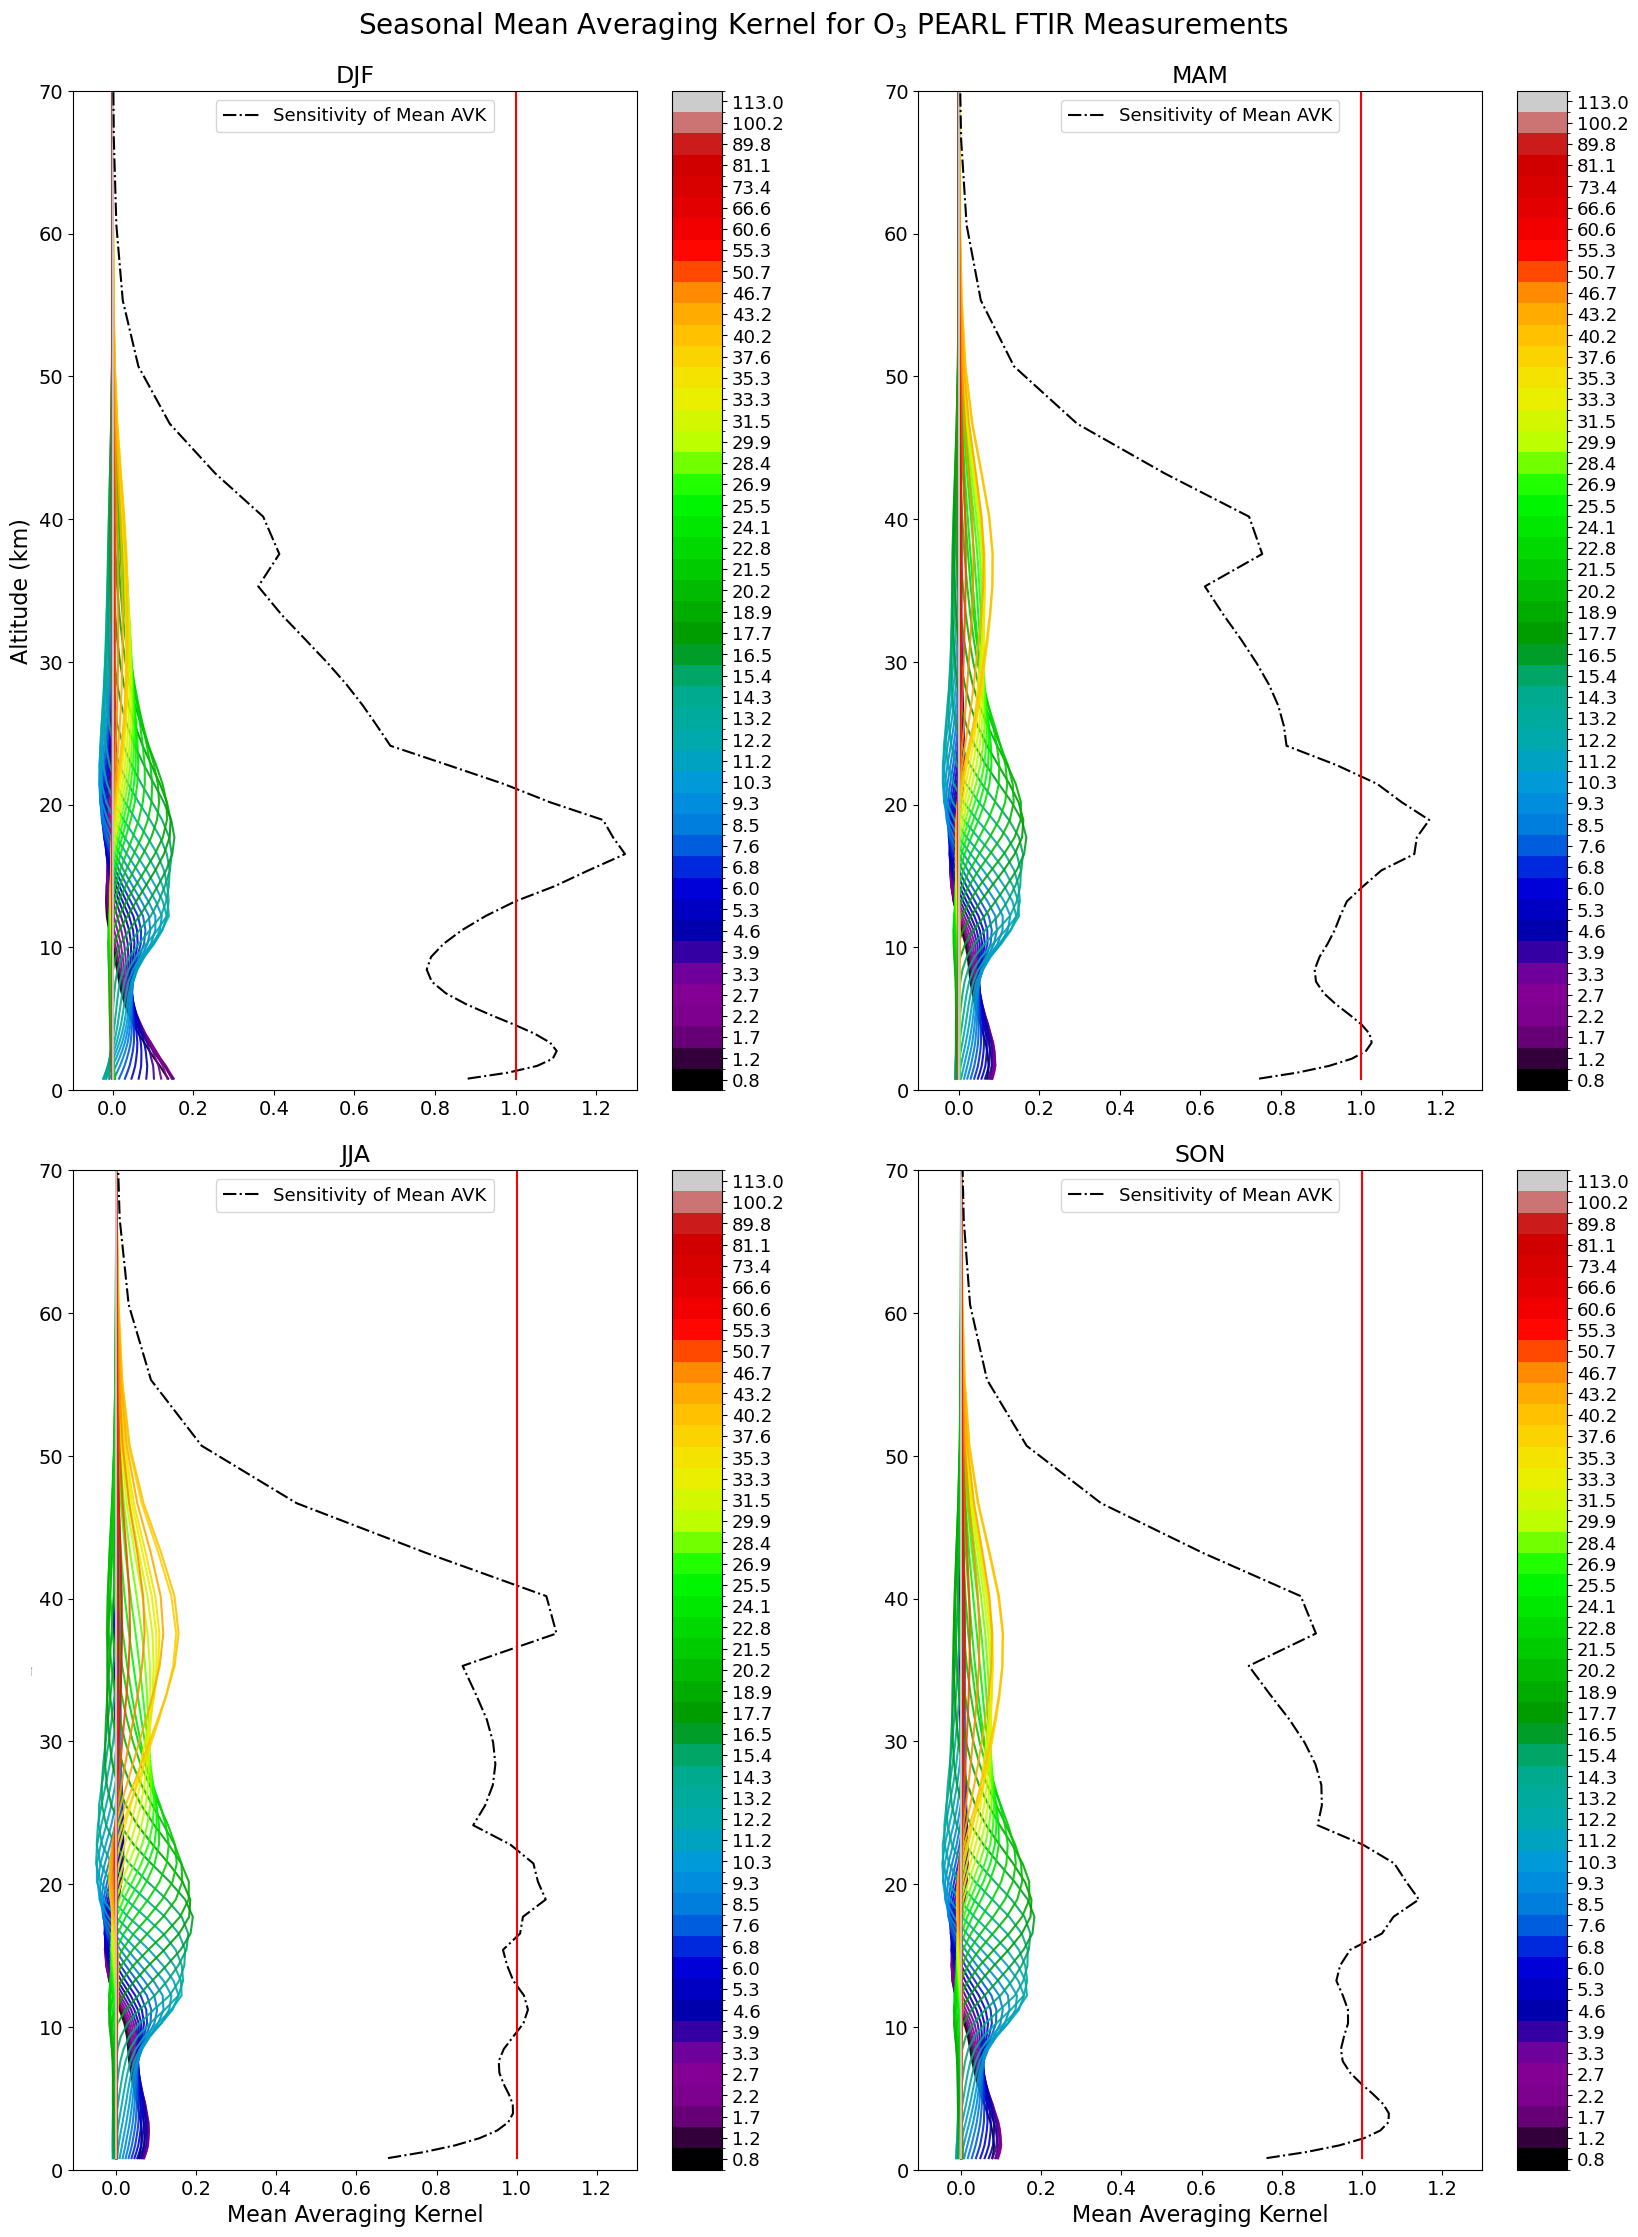

In [18]:
fig, axes = plt.subplots(2,2, figsize=(20, 27))
for i, season in enumerate(seasonal_months):
    ax = axes.flat[i]
    mean_avk = np.nanmean(seasonal_AVKS[season], axis = 0)
    alts     = f["altitude1"].values

    cmap = plt.get_cmap("nipy_spectral", 47)
    colors = cmap(np.arange(47))

    for i in range(mean_avk.shape[0]):
        ax.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

    ax.set_ylim(0, 70)
    ax.set_title(season, fontsize = 17)
    
    ax.tick_params(axis='both', labelsize=14)

    sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

    cbar = fig.colorbar(sm, ax=ax,
                        boundaries=bounds,
                        ticks=alts,
                        spacing='uniform') 

    ax.plot(np.nansum(mean_avk, axis = 1), alts, color='black', ls='-.', label = "Sensitivity of Mean AVK")  

    ax.set_xlim(right = 1.3)

    ax.plot([1] * len(alts), alts, color='red', ls='-')

    ax.legend()

bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

fig.subplots_adjust(hspace=0.08)

axes.flat[2].set_xlabel("Mean Averaging Kernel", fontsize = 16)
axes.flat[3].set_xlabel("Mean Averaging Kernel", fontsize = 16)

axes.flat[0].set_ylabel("Altitude (km)", fontsize = 16)
axes.flat[2].set_ylabel("Altitude (km)", fontsize = 1)

plt.suptitle("Seasonal Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 0.91, fontsize = 20)

title = fig._suptitle.get_text()
fig.savefig(title + "(with sensitivity)", bbox_inches="tight")

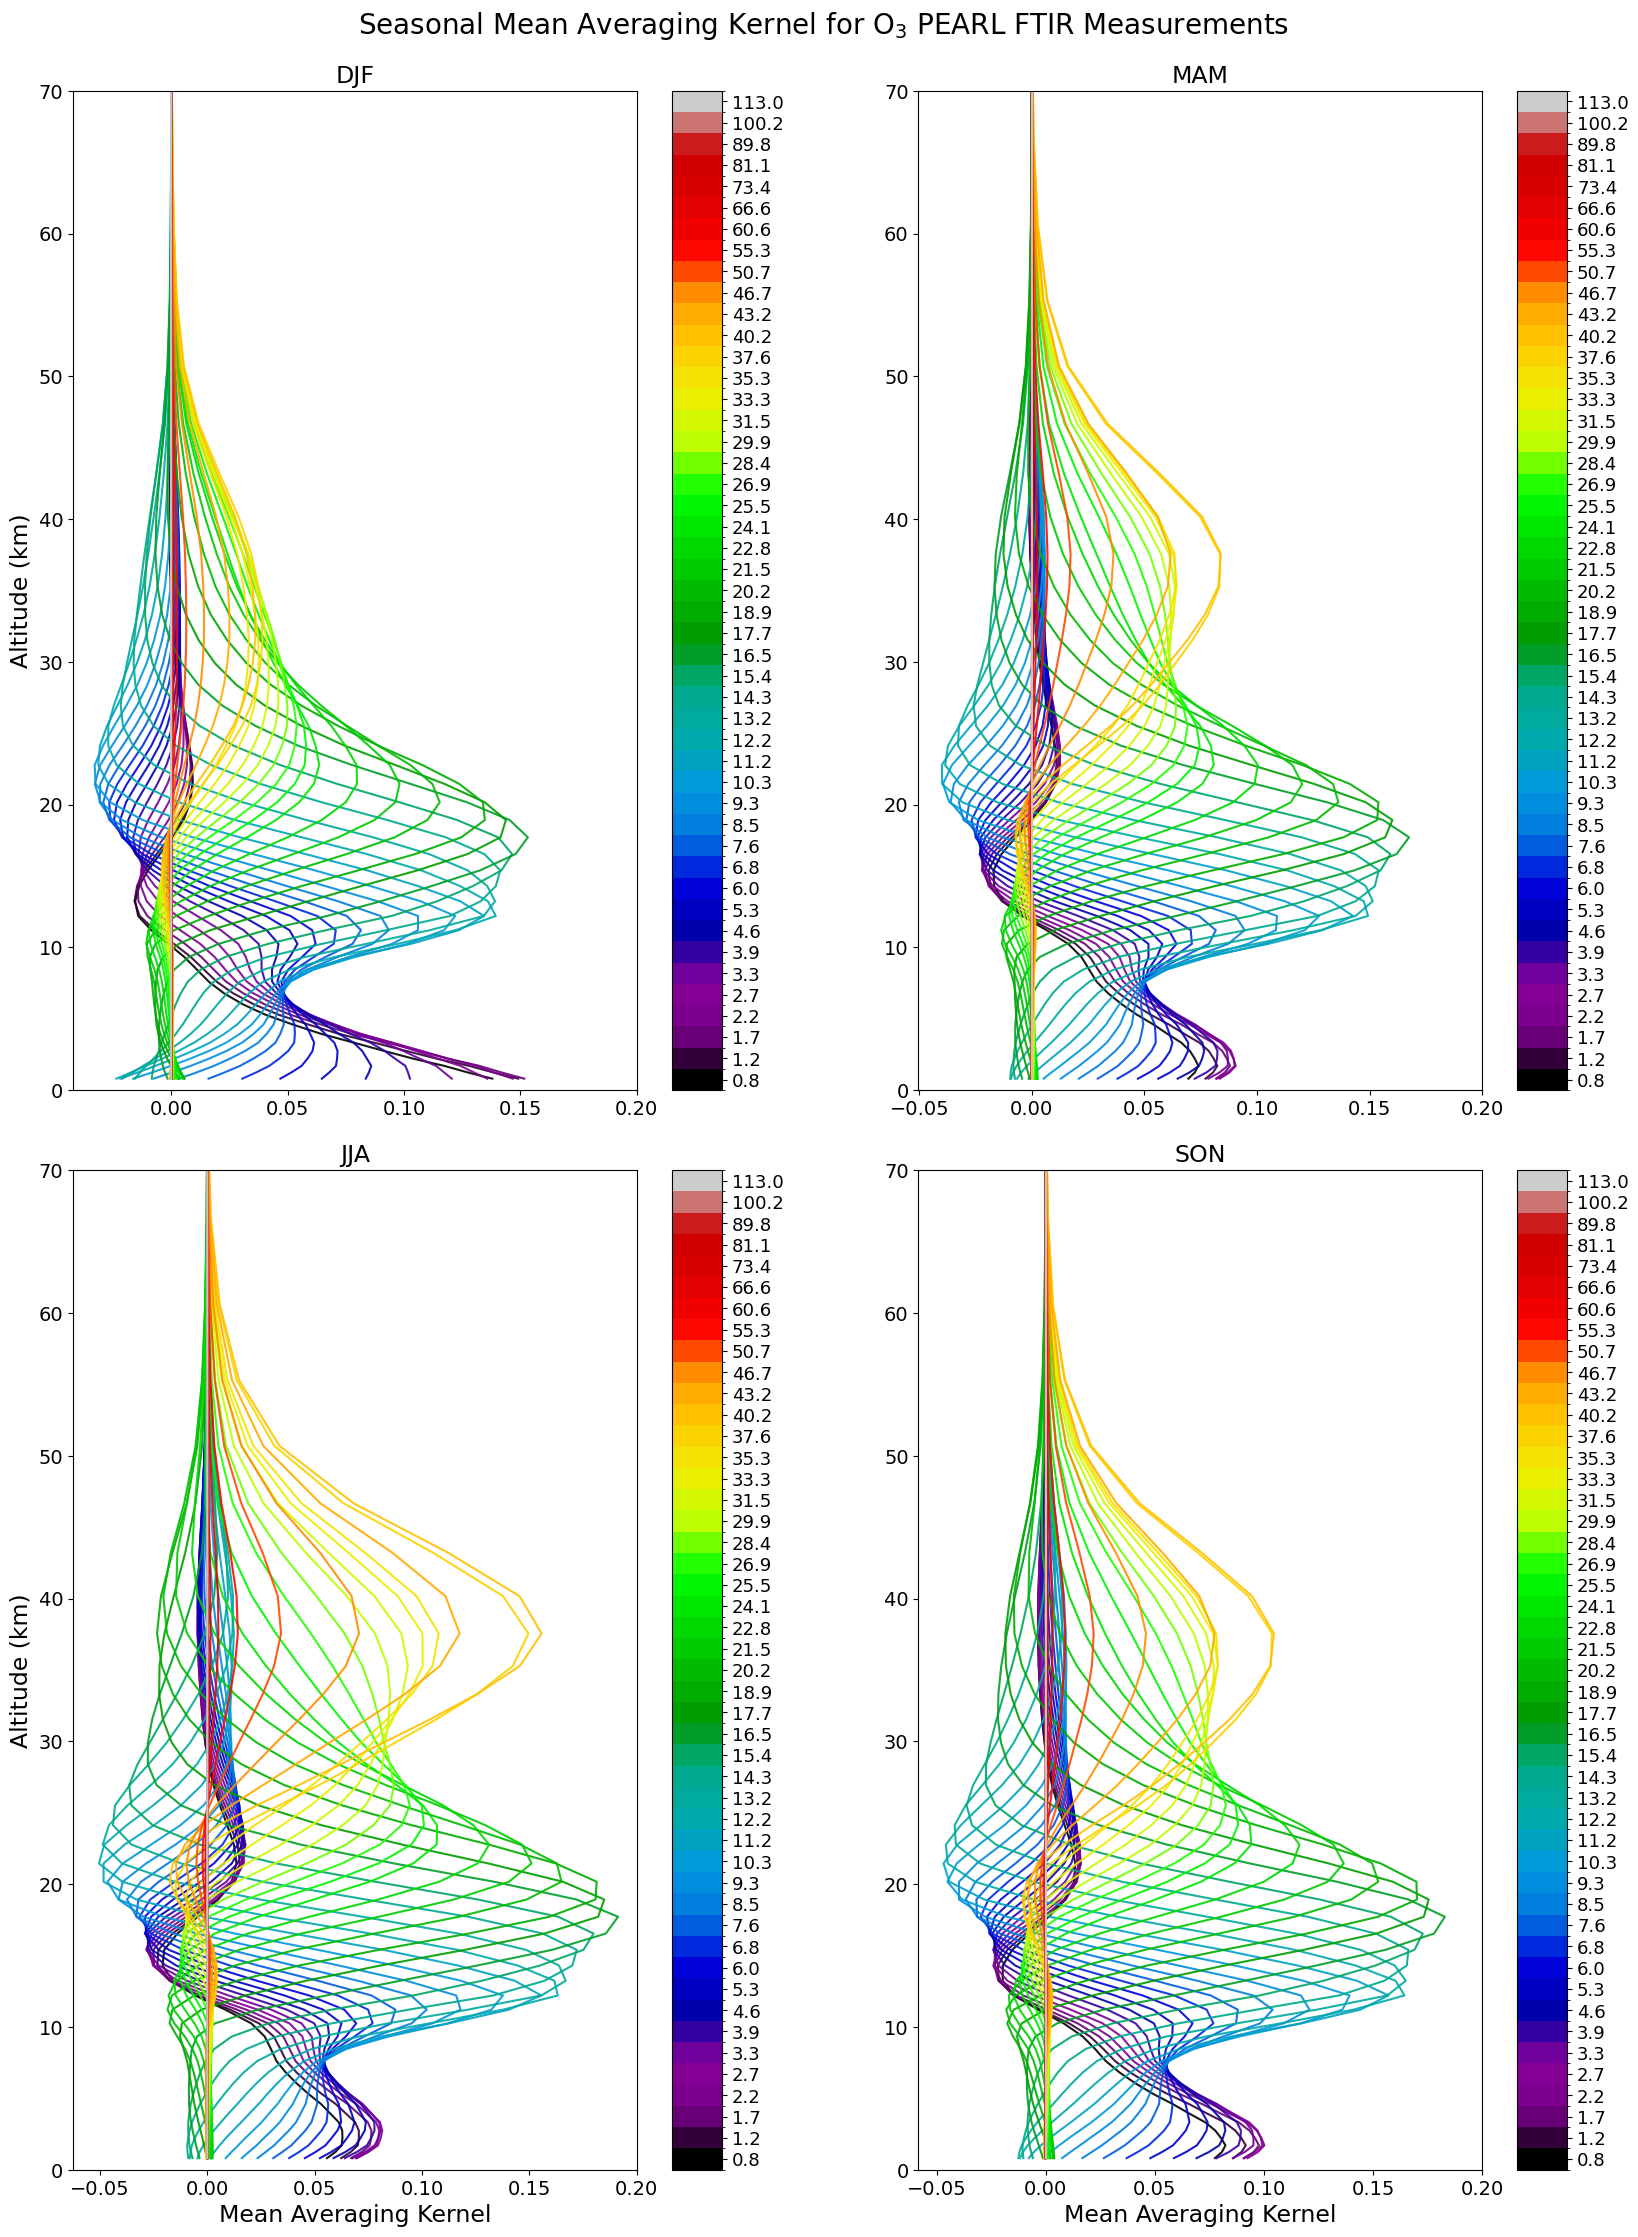

In [19]:
fig, axes = plt.subplots(2,2, figsize=(20, 27))
for i, season in enumerate(seasonal_months):
    ax = axes.flat[i]
    mean_avk = np.nanmean(seasonal_AVKS[season], axis = 0)
    alts     = f["altitude1"].values

    cmap = plt.get_cmap("nipy_spectral", 47)
    colors = cmap(np.arange(47))

    for i in range(mean_avk.shape[0]):
        ax.plot(mean_avk[i, :], alts, color=colors[i], alpha = 0.9)

    ax.set_ylim(0, 70)
    ax.set_title(season, fontsize = 17)
    
    ax.tick_params(axis='both', labelsize=14)

    sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

    cbar = fig.colorbar(sm, ax=ax,
                        boundaries=bounds,
                        ticks=alts,
                        spacing='uniform')   
    
    ax.set_xlim(right = 0.2)

bounds = np.unique(f["ALTITUDE.BOUNDARIES"][0].values.flatten())
lcmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, lcmap.N)

sm = mpl.cm.ScalarMappable(cmap=lcmap, norm=norm)

fig.subplots_adjust(hspace=0.08)

axes.flat[2].set_xlabel("Mean Averaging Kernel", fontsize = 17)
axes.flat[3].set_xlabel("Mean Averaging Kernel", fontsize = 17)

axes.flat[0].set_ylabel("Altitude (km)", fontsize = 17)
axes.flat[2].set_ylabel("Altitude (km)", fontsize = 17)


plt.suptitle("Seasonal Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 0.91, fontsize = 20)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [20]:
years = np.unique(pd_measurement_times.year)
yearly_measurement_idx = {year: np.where(pd_measurement_times.year.isin([year]))[0]
                            for i, year in enumerate(years)}

yearly_AVKS = {year: AVKS[idxs, :]
                for year, idxs in yearly_measurement_idx.items()}

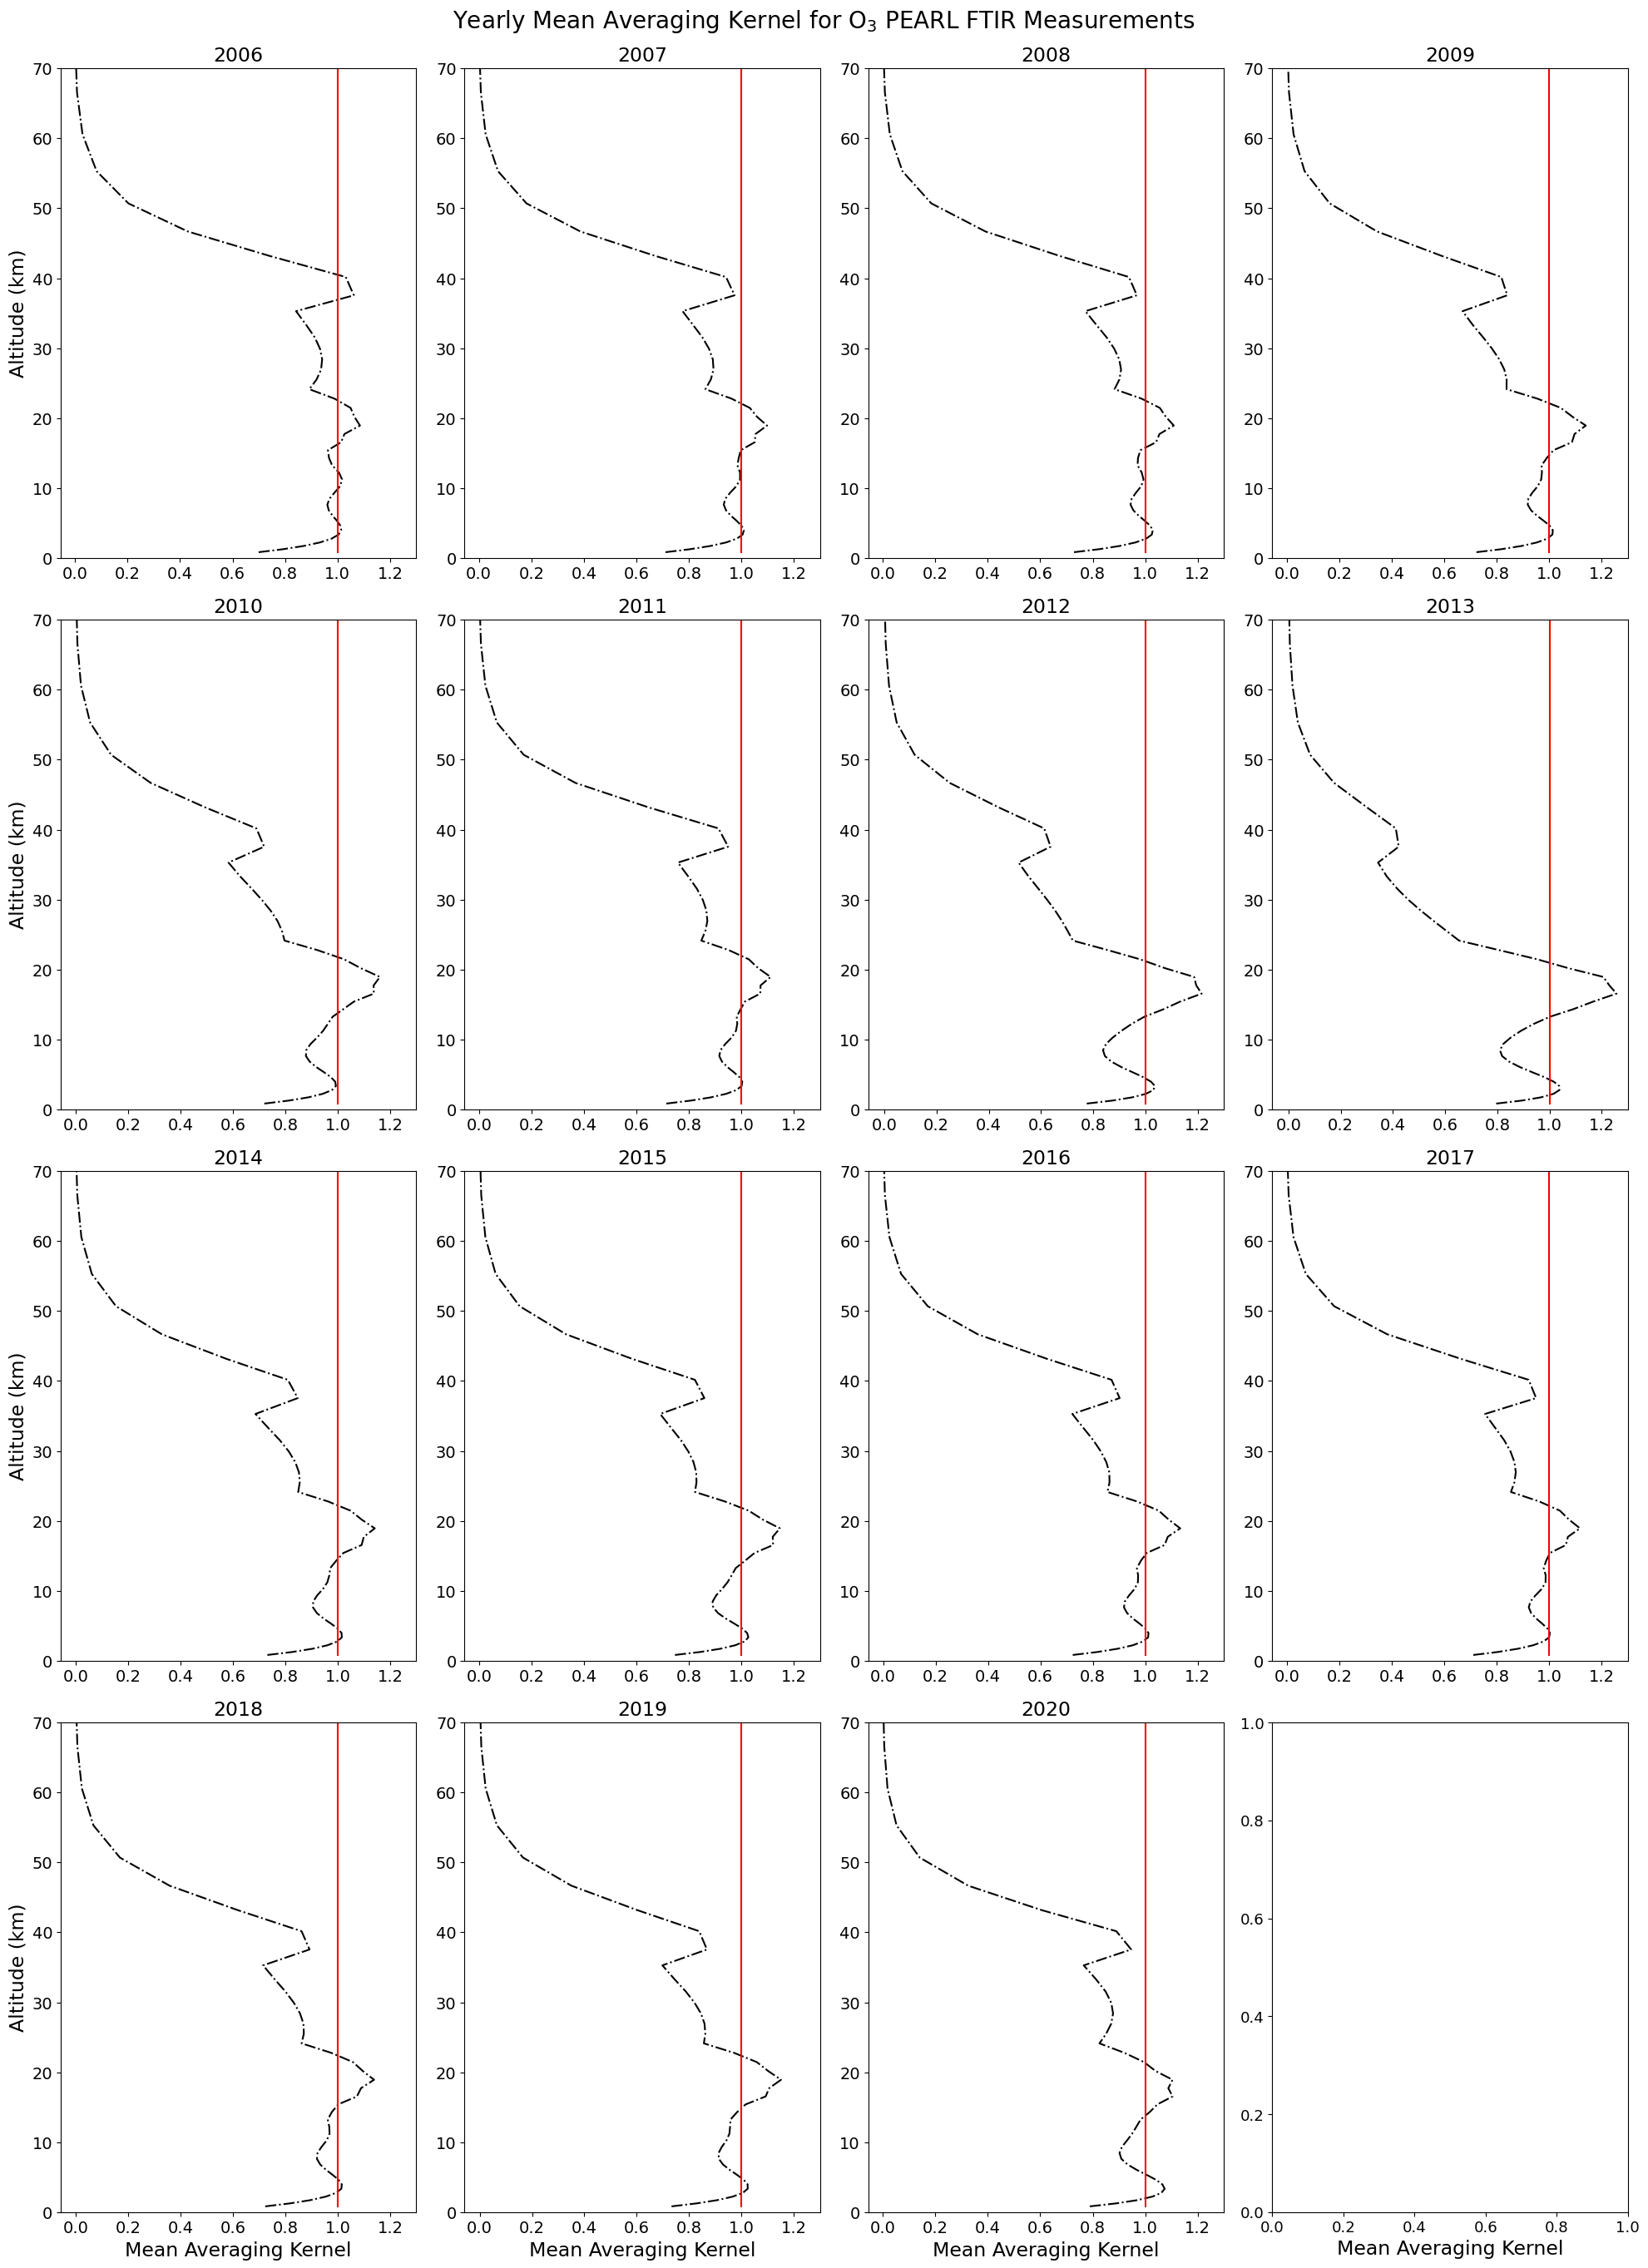

In [21]:
fig, axes = plt.subplots(4,4, figsize=(20, 27))
for i, year in enumerate(years):
    ax = axes.flat[i]
    mean_avk = np.nanmean(yearly_AVKS[year], axis = 0)
    alts     = f["altitude1"].values

    cmap = plt.get_cmap("nipy_spectral", 47)
    colors = cmap(np.arange(47))

    ax.plot(np.nansum(mean_avk, axis = 1), alts, color='black', ls='-.', label = "Sensitivity of Mean AVK")  

    ax.plot([1] * len(alts), alts, color='red', ls='-', label = "Sensitivity of Mean AVK")  

    ax.set_ylim(0, 70)
    ax.set_xlim(right = 1.3)
    ax.set_title(year, fontsize = 17)
    
    ax.tick_params(axis='both', labelsize=14)

fig.subplots_adjust(hspace=0.08)

axes.flat[15].set_xlabel("Mean Averaging Kernel", fontsize = 17)
axes.flat[14].set_xlabel("Mean Averaging Kernel", fontsize = 17)
axes.flat[13].set_xlabel("Mean Averaging Kernel", fontsize = 17)
axes.flat[12].set_xlabel("Mean Averaging Kernel", fontsize = 17)

axes.flat[12].set_ylabel("Altitude (km)", fontsize = 17)
axes.flat[8].set_ylabel("Altitude (km)", fontsize = 17)
axes.flat[0].set_ylabel("Altitude (km)", fontsize = 17)
axes.flat[4].set_ylabel("Altitude (km)", fontsize = 17)

fig.tight_layout()
plt.suptitle("Yearly Mean Averaging Kernel for O$_3$ PEARL FTIR Measurements", y = 1.01, fontsize = 20)

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [22]:
diag_sums = [np.trace(avk) for avk in AVKS]

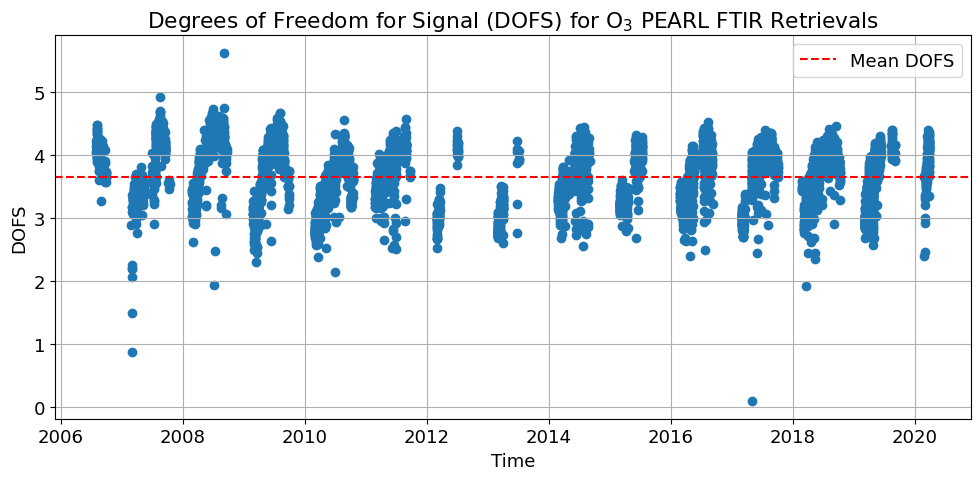

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(DATETIME, diag_sums)
plt.title("Degrees of Freedom for Signal (DOFS) for O$_3$ PEARL FTIR Retrievals")
plt.xlabel("Time")
plt.ylabel("DOFS")
plt.grid(True)
plt.tight_layout()

mean_dofs = np.nanmean(diag_sums)
fig = plt.gcf()
axes = plt.gca()

plt.gca().axhline(mean_dofs, color = "red", linestyle = "dashed", label = "Mean DOFS")
plt.legend()


title = axes.get_title()
fig.savefig(title + "(All Time)", bbox_inches="tight")

In [24]:
pd.DataFrame(days_of_year)
# pd.DataFrame(days_of_year).groupby(by=0).agg(max)
diag_sums = [np.trace(avk) for avk in AVKS]
max_dofs = pd.DataFrame(data = {"days_of_year": days_of_year, "diag_sums": diag_sums}).groupby(by = "days_of_year").agg("max")
avg_dofs = pd.DataFrame(data = {"days_of_year": days_of_year, "diag_sums": diag_sums}).groupby(by = "days_of_year").agg("mean")
# days_of_year
max_dofs

diag_sums
days_of_year           
54             3.677237
55             3.586176
56             3.466885
57             3.503064
58             3.573736
...                 ...
279            3.289314
280            3.788282
285            3.607003
286            3.823480
289            3.545881

[227 rows x 1 columns]

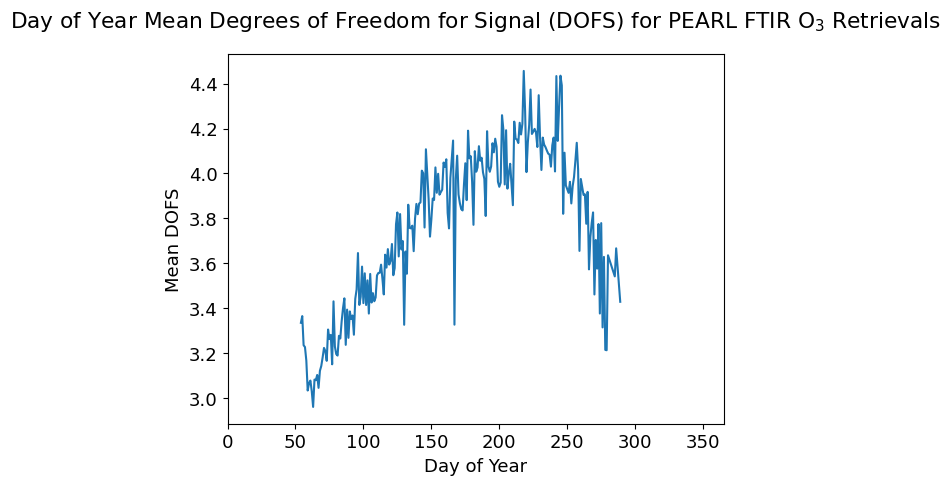

In [25]:
plt.plot(avg_dofs.index, avg_dofs["diag_sums"])
plt.title("Day of Year Mean Degrees of Freedom for Signal (DOFS) for PEARL FTIR O$_3$ Retrievals", y = 1.05)
plt.xlabel("Day of Year")
plt.ylabel("Mean DOFS")
plt.xlim(0,365)

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [26]:
max_dofs.loc[289]
normalized_diag_sums = diag_sums/max(diag_sums)

C:\Users\salla\AppData\Local\Temp\ipykernel_23540\386919050.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


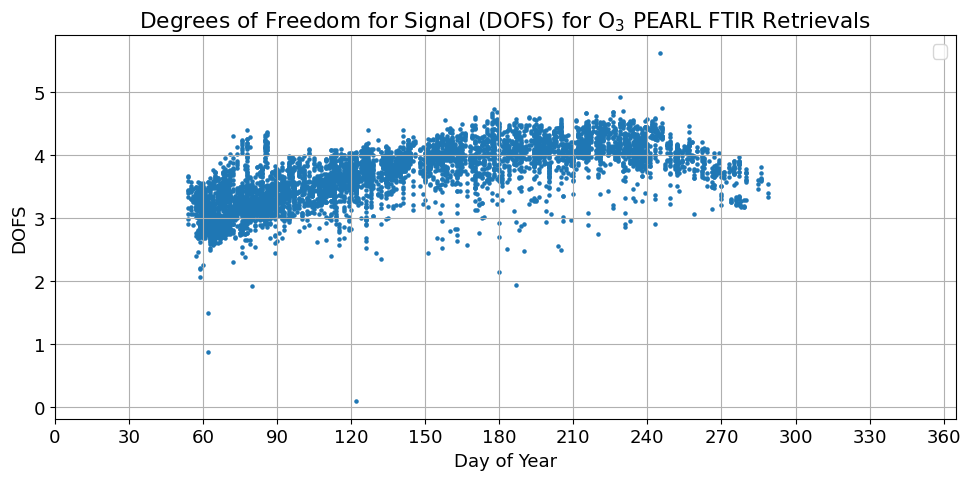

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(days_of_year, diag_sums, s = 5)
plt.title("Degrees of Freedom for Signal (DOFS) for O$_3$ PEARL FTIR Retrievals")
plt.xlabel("Day of Year")
plt.ylabel("DOFS")
plt.grid(True)
plt.tight_layout()
plt.xlim(0,365)

mean_dofs = np.nanmean(diag_sums)
fig = plt.gcf()
axes = plt.gca()

axes.xaxis.set_major_locator(mpl.ticker.FixedLocator([i for i in range(0,361,30)]))
title = axes.get_title()
fig.savefig(title + "(no ylim)", bbox_inches="tight")
plt.legend()

C:\Users\salla\AppData\Local\Temp\ipykernel_23540\3873703774.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


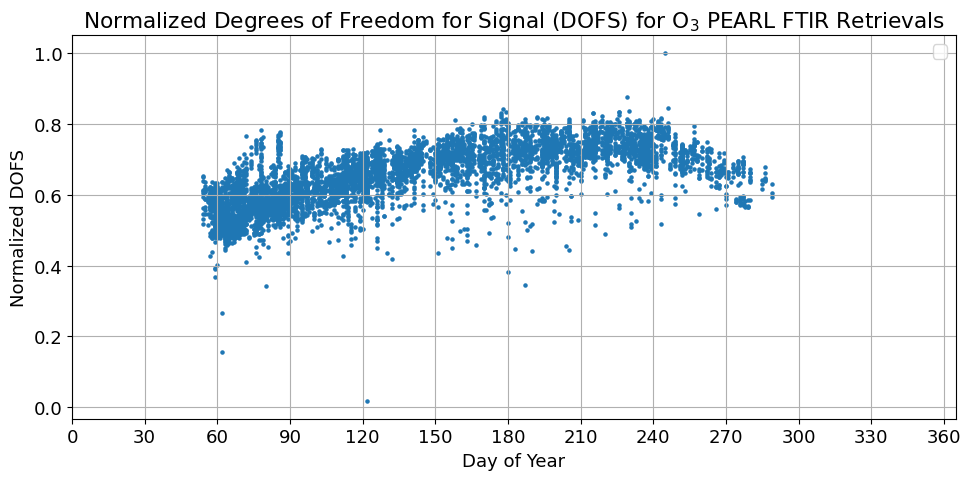

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(days_of_year, normalized_diag_sums, s = 5)
plt.title("Normalized Degrees of Freedom for Signal (DOFS) for O$_3$ PEARL FTIR Retrievals")
plt.xlabel("Day of Year")
plt.ylabel("Normalized DOFS")
plt.grid(True)
plt.tight_layout()
plt.xlim(0,365)
# plt.ylim(0.6,1)

mean_dofs = np.nanmean(diag_sums)
fig = plt.gcf()
axes = plt.gca()

axes.xaxis.set_major_locator(mpl.ticker.FixedLocator([i for i in range(0,361,30)]))
title = axes.get_title()
fig.savefig(title, bbox_inches="tight")
plt.legend()

In [29]:
unique_times, unique_indices, unique_counts = np.unique(pd.to_datetime(DATETIME).date, return_counts = True, return_index = True)
start_idx = np.concatenate((np.array([0]), np.cumsum(unique_counts)[:-1]))

diag_sums = np.array([np.trace(avk) for avk in AVKS])

day_ids = np.repeat(np.arange(len(unique_counts)), unique_counts)

daily_max = np.array([
    diag_sums[day_ids == d].max() 
    for d in range(len(unique_counts))
])

normed = diag_sums / daily_max[day_ids]

daily_plot = [(DATETIME[j:j+counts], normed[j:j+counts]) for j, counts in zip(start_idx, unique_counts)]

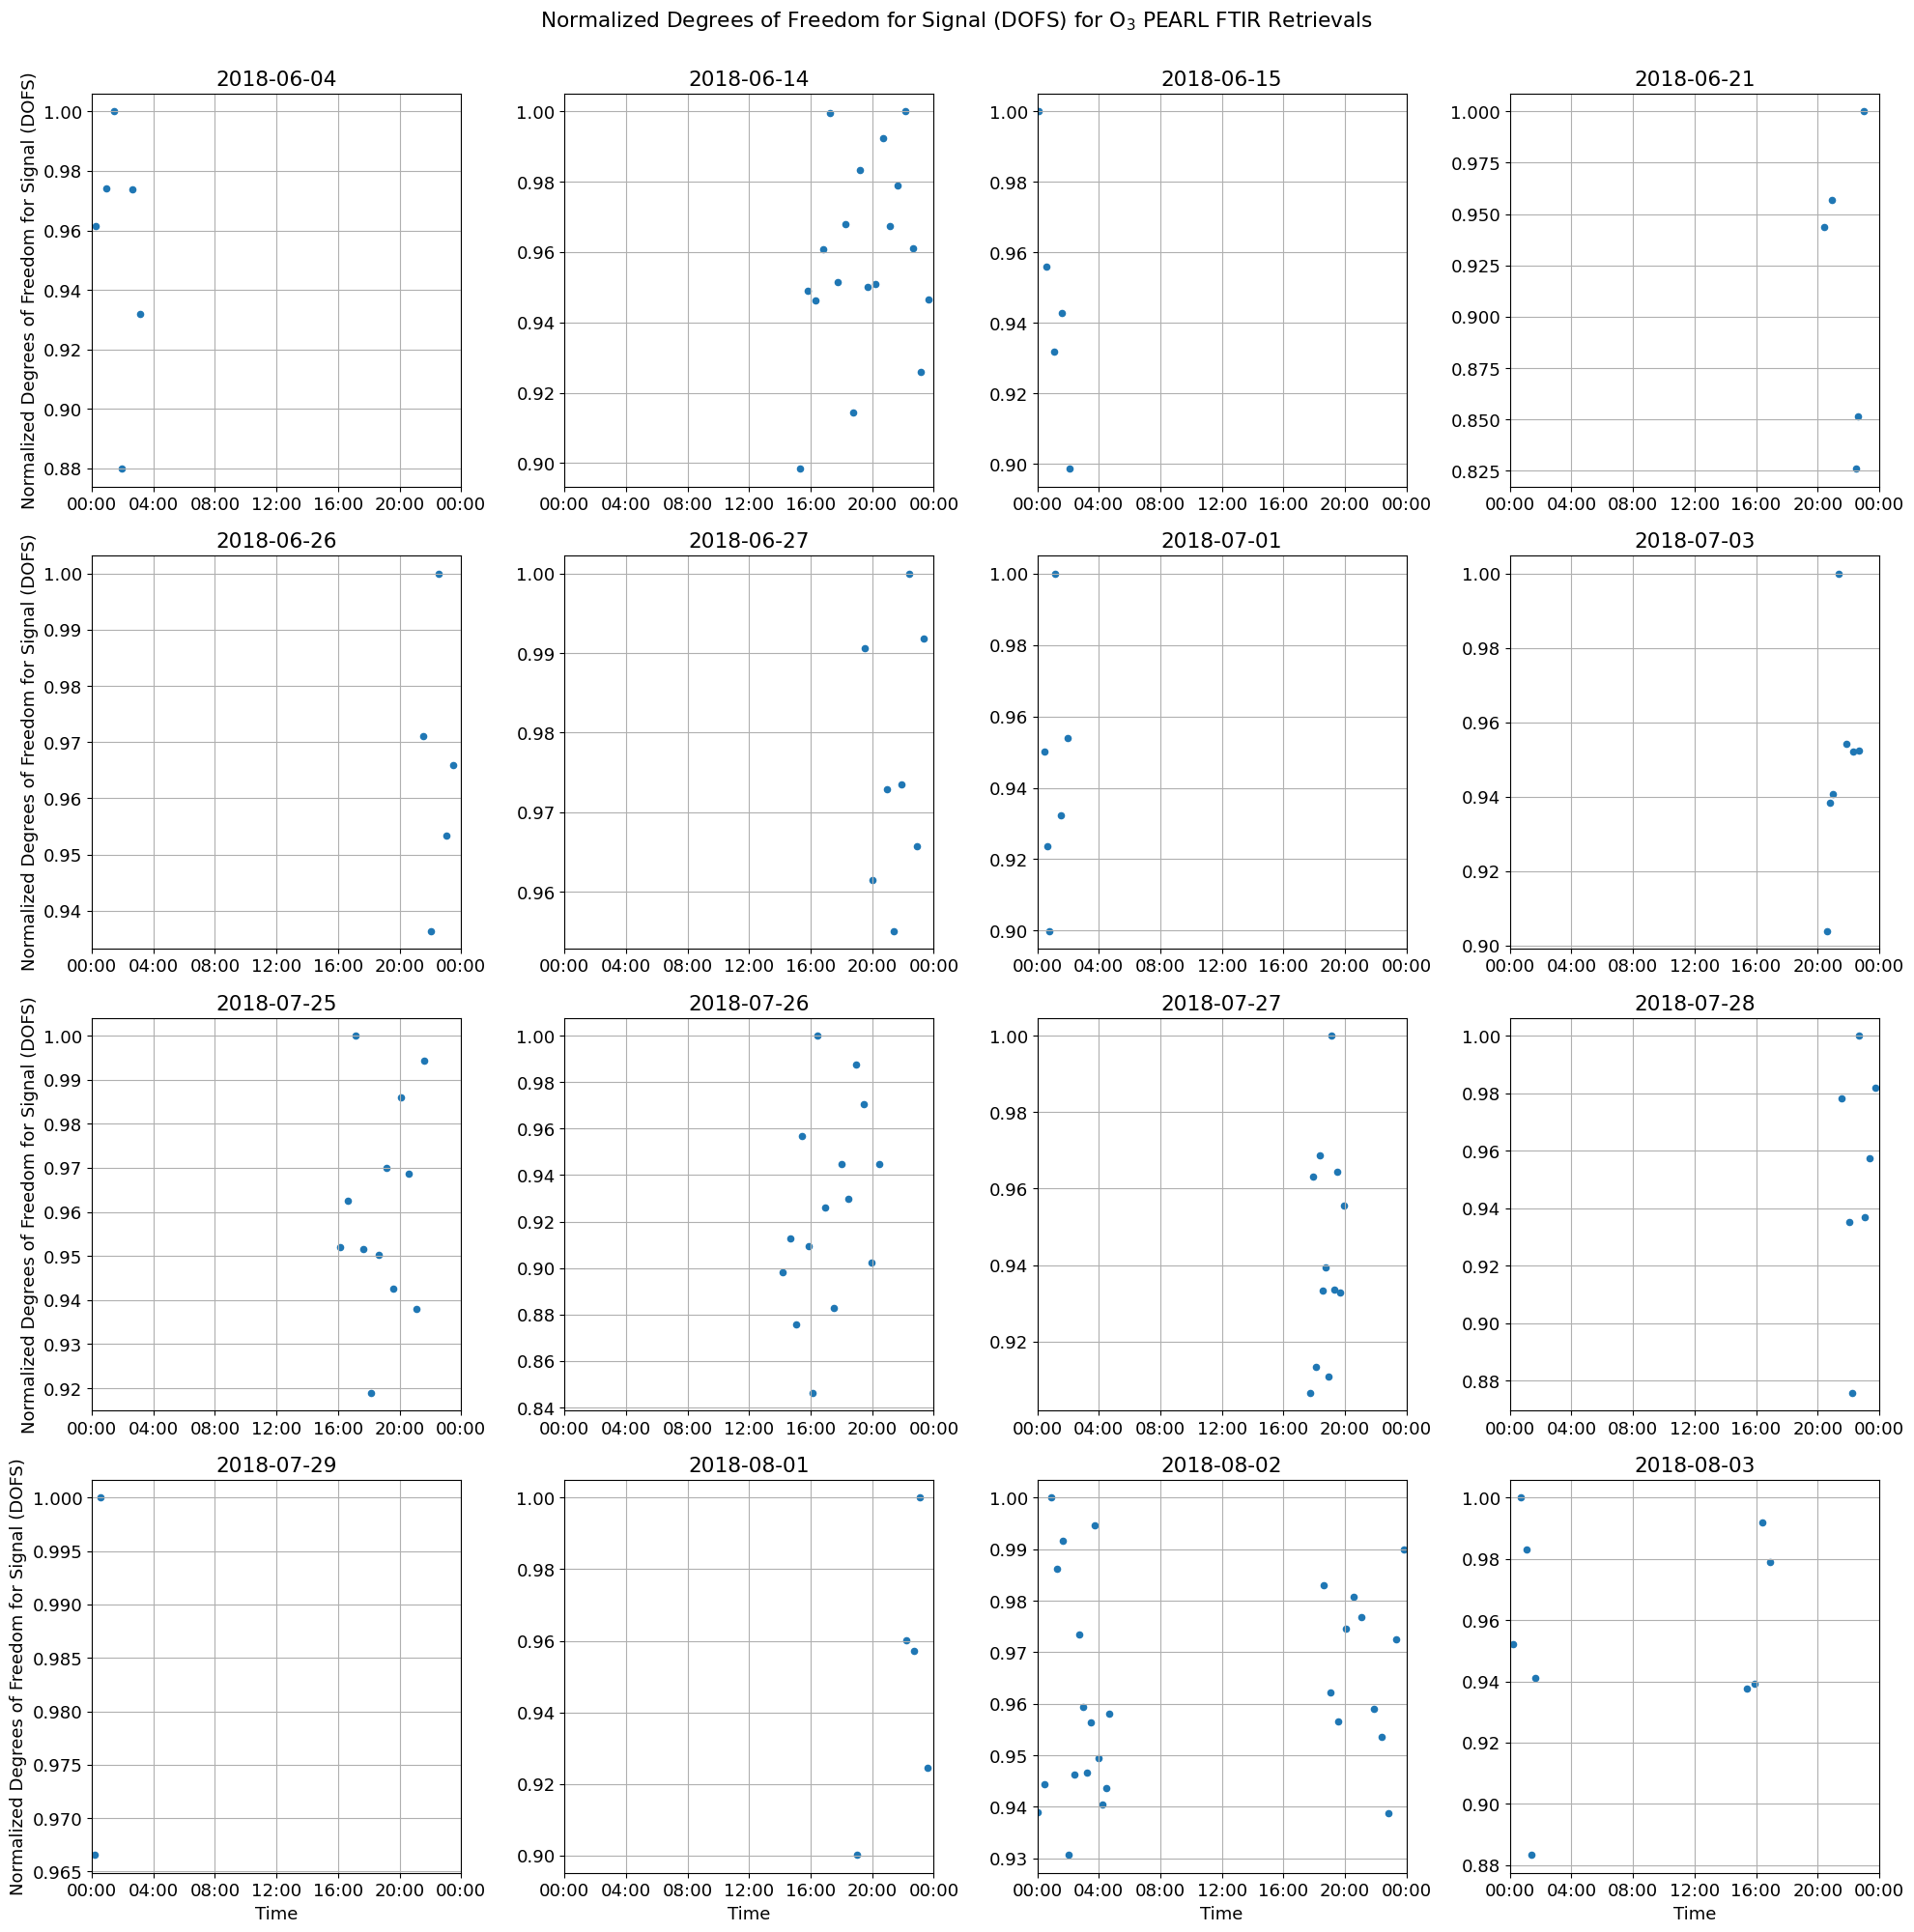

In [30]:
fig, axes = plt.subplots(4,4, figsize = (20,20))
start_plot_idx = 820
pd_unique_times = pd.to_datetime(unique_times).strftime("%Y-%m-%d")
for i, ax in enumerate(axes.flat):
    ax.scatter(*daily_plot[start_plot_idx + i], color="C0", s=20, alpha=1)
    if i in [0,4,8,12]:
        ax.set_ylabel("Normalized Degrees of Freedom for Signal (DOFS)")
    if i in [12,13,14,15]:
        ax.set_xlabel("Time")
    # ax.set_title(pd.to_datetime(unique_times))
    ax.set_title(pd_unique_times[start_plot_idx + i])
    ax.grid(True)
    start = mpl.dates.date2num(unique_times[start_plot_idx + i])
    end = start + 1
    locator = mpl.dates.HourLocator(interval = 4)
    formatter = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # ax.set_xticklabels()
    ax.set_xlim(start, end)
    
#what time is it in?
plt.suptitle("Normalized Degrees of Freedom for Signal (DOFS) for O$_3$ PEARL FTIR Retrievals", y = 1)

plt.tight_layout()
fig = plt.gcf()
axes = plt.gca()

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [31]:
O3_vmr = f["O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR"] * 1e-6
O3_times = O3_vmr.sel(DATETIME = slice("2006-01-01", "2020-12-31"))
latitude = 80.05
longitude = -86.42
altitude1 = O3_times["altitude1"].values

In [32]:
temperature = f["TEMPERATURE_INDEPENDENT"]
pressure = f["PRESSURE_INDEPENDENT"] * 100
k = 1.380649e-23
O3_density = O3_vmr * pressure/(k * temperature)
# vmr - mol o3/mol air
# mol o3/mol air * mol air/vol air = num density = vmr * mol air/vol air = mol o3/vol air in molecules/m^3
# mol air/vol air = N/V
# PV = NkT
# N/V = P/kT
# num density = vmr * N/V = vmr * P/kT
# column = num density*altitude diff

C:\Users\salla\AppData\Local\Temp\ipykernel_23540\2609900276.py:13: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(has_fig.axes.flat):


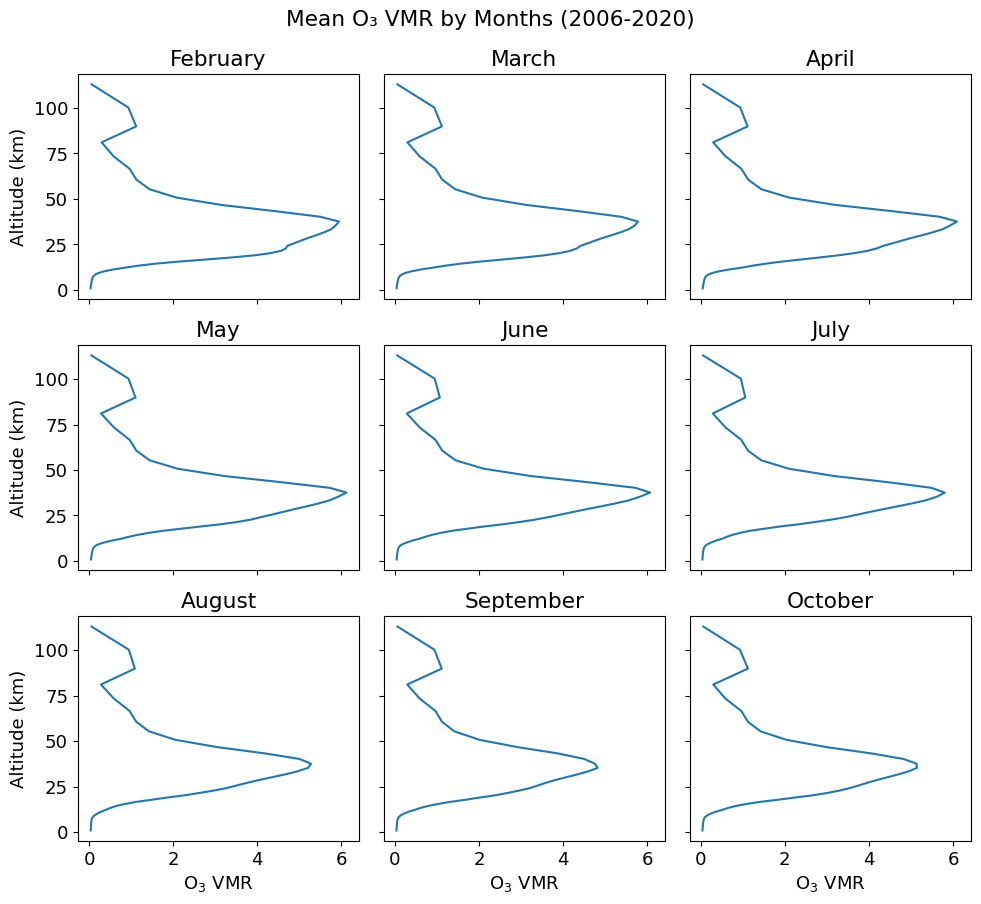

In [33]:
has_fig = (((O3_times).groupby("DATETIME.month").mean(dim  = "DATETIME") * 10**6)).plot(col = "month", col_wrap = 3, y = "altitude1")
has_fig.fig.axes[0].set_ylabel("Altitude (km)")
has_fig.fig.axes[3].set_ylabel("Altitude (km)")
has_fig.fig.axes[6].set_ylabel("Altitude (km)")
has_fig.fig.axes[6].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[7].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[8].set_xlabel("O$_3$ VMR")

plt.suptitle("Mean O₃ VMR by Months (2006-2020)", y = 1.025)

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i, ax in enumerate(has_fig.axes.flat):
    ax.set_title(month_names[i + 1])

title = has_fig.fig._suptitle.get_text()
has_fig.fig.savefig(title, bbox_inches="tight")

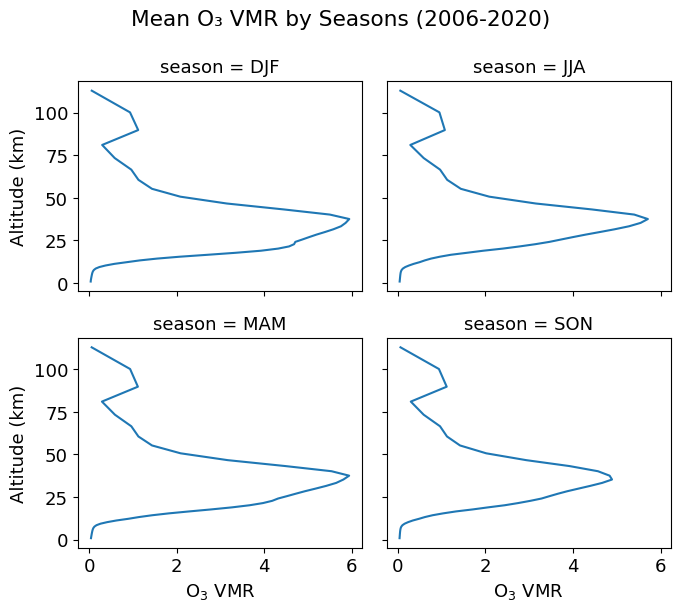

In [34]:
has_fig = (O3_times.groupby("DATETIME.season").mean(dim  = "DATETIME") * 10**6).plot(col = "season", col_wrap = 2, y = "altitude1")
has_fig.fig.axes[0].set_ylabel("Altitude (km)")
has_fig.fig.axes[2].set_ylabel("Altitude (km)")
has_fig.fig.axes[2].set_xlabel("O$_3$ VMR")
has_fig.fig.axes[3].set_xlabel("O$_3$ VMR")

plt.suptitle("Mean O₃ VMR by Seasons (2006-2020)", y = 1.05)

title = has_fig.fig._suptitle.get_text()
has_fig.fig.savefig(title, bbox_inches="tight")

In [35]:
 def get_column(min_alt=None, max_alt=None):
    if min_alt is None or max_alt is None:
        raise ValueError("Both min_alt and max_alt must be provided")
    if min_alt > max_alt:
        min_alt, max_alt = max_alt, min_alt
        
    alt_boundaries = f["ALTITUDE.BOUNDARIES"][0]
    lower_bounds = alt_boundaries[1].values
    upper_bounds = alt_boundaries[0].values
    layer_thickness = upper_bounds - lower_bounds
    
    alt_min = np.min(lower_bounds)
    alt_max = np.max(upper_bounds)
    min_alt_clamped = max(min_alt, alt_min)
    max_alt_clamped = min(max_alt, alt_max)

    min_mask = (lower_bounds <= min_alt_clamped) & (min_alt_clamped < upper_bounds)
    max_mask = (lower_bounds < max_alt_clamped) & (max_alt_clamped <= upper_bounds)
    
    if not np.any(min_mask):
        print(alt_min, min_alt, min_alt_clamped)
        raise ValueError(f"min_alt {min_alt}km outside profile range after clamping")
    else:
        min_idx = np.where(min_mask)[0][0]

    if not np.any(max_mask):
        raise ValueError(f"max_alt {max_alt}km outside profile range after clamping")
    else:
        max_idx = np.where(max_mask)[0][0]

    min_proportion = (upper_bounds[min_idx] - min_alt_clamped) / layer_thickness[min_idx]
    max_proportion = (max_alt_clamped - lower_bounds[max_idx]) / layer_thickness[max_idx]
    
    O3_density = get_density()

    pre_partial_column = xr.zeros_like(O3_density)
    
    if min_idx == max_idx:
        proportion = (max_alt_clamped - min_alt_clamped) / layer_thickness[min_idx]
        pre_partial_column[{"altitude1": min_idx}] = ((f["O3.COLUMN.PARTIAL_ABSORPTION.SOLAR"] * 10000).isel(altitude1=min_idx)
            * proportion
        )
    else:
        pre_partial_column[{"altitude1": min_idx}] = (
            O3_density.isel(altitude1=min_idx) 
            * layer_thickness[min_idx]
            * 1000 
            * min_proportion
        )
        
        if max_idx - min_idx > 1:
            mid_slice = slice(min_idx+1, max_idx)
            pre_partial_column[{"altitude1": mid_slice}] = ((f["O3.COLUMN.PARTIAL_ABSORPTION.SOLAR"] * 10000).isel(altitude1=mid_slice)
            )
        
        pre_partial_column[{"altitude1": max_idx}] = (
            O3_density.isel(altitude1=max_idx)
            * layer_thickness[max_idx]
            * 1000
            * max_proportion
        )

    partial_column = pre_partial_column.sum(dim="altitude1", skipna=True)
    all_nan = pre_partial_column.isnull().all(dim="altitude1")
    partial_column = partial_column.where(~all_nan)
    return partial_column


def get_column_DU(min_alt = None, max_alt = None):
    _conversion_factor = 2.687e20
    O3_partial_column = get_column(min_alt, max_alt)
    return O3_partial_column / _conversion_factor


def get_vmr():
    return O3_vmr


def get_temperature():
    return f["TEMPERATURE_INDEPENDENT"]


def get_pressure():
    return f["PRESSURE_INDEPENDENT"] * 100


def get_density():
    return O3_vmr * get_pressure()/(1.380649e-23 * get_temperature())

In [36]:
from math import sin, cos, pi
col_51 = get_column_DU(0, alts[38])
col_51_DATETIME = col_51["DATETIME"].values
col_51_FLOATTIME = col_51_DATETIME.astype("float64")
max_time = max(col_51_FLOATTIME)
year_to_ns = 3.154e+16
slope, intercept = np.polyfit(col_51_FLOATTIME, col_51, 1)
line = slope * col_51_FLOATTIME + intercept
reg_residuals = col_51 - line
def sin_fit(x, A, shift, angular_frequency):
    return A * sin(angular_frequency * x + shift)
full_fit = line + np.array([sin_fit(time, 170, pi/(2+1), (pi/(year_to_ns / 2))) for time in col_51_FLOATTIME])

full_fit

array([205.44948338, 205.45136594, 205.45323723, ..., 478.66060026,
       478.60652714, 478.55171428])

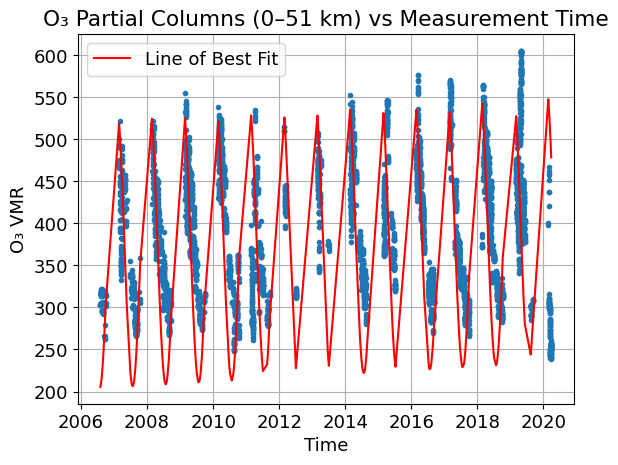

In [37]:

# (get_column_DU(0, alts[38])).plot(size = 7)
plt.plot(col_51_DATETIME, col_51, marker = ".", linestyle = "None")
# plt.plot(col_51_DATETIME, [300 * sin((pi/year_to_ns) * time) + 500 for time in col_51_FLOATTIME])


plt.plot(col_51_DATETIME, full_fit, color = "red", label = "Line of Best Fit")
plt.legend()


plt.ylabel("O₃ VMR")
plt.xlabel("Time")
plt.title(f"O₃ Partial Columns (0–{alts[38]:.0f} km) vs Measurement Time")
plt.grid(True)

fig = plt.gcf()
axes = plt.gca()


# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")

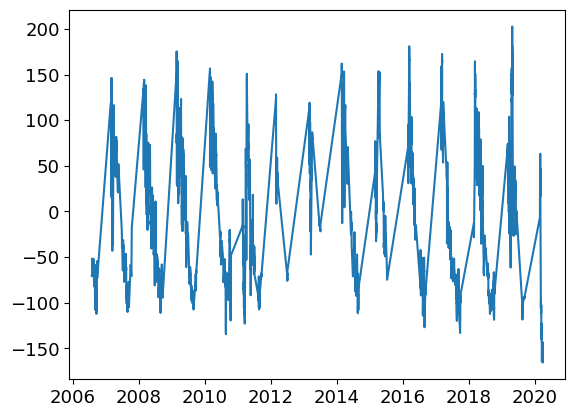

In [38]:

# plt.plot(col_51_DATETIME, reg_residuals, linestyle = "None", marker = ".")
plt.plot(col_51_DATETIME, reg_residuals)
# plt.plot(col_51_DATETIME, [150 * sin((pi/(year_to_ns / 2)) * time + pi/(2+1)) for time in col_51_FLOATTIME])

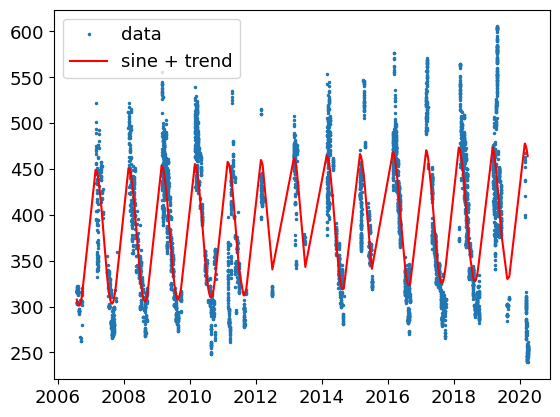

In [39]:
def model(x, A, omega, phi):
    return A*np.sin(omega*x + phi)

from scipy.optimize import curve_fit

x_data = col_51_FLOATTIME
y_data = reg_residuals
p0 = [ 300,   # A_0
       (pi/(year_to_ns / 2)),        # omega_0
       pi/(3)                                # phi_0
     ]

popt, pcov = curve_fit(model, x_data, y_data, p0=p0)
A_fit, omega_fit, phi_fit = popt

y_fit = model(x_data, *popt)
# plt.plot(col_51_DATETIME, col_51, label='data')
plt.plot(col_51_DATETIME, col_51, label='data', marker = ".", linestyle = "None", markersize = 3)
plt.plot(col_51_DATETIME, y_fit + line, color='red', label='sine + trend')
plt.legend()


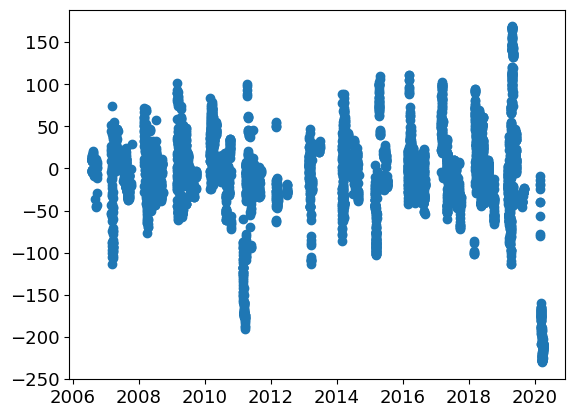

In [40]:
plt.scatter(col_51_DATETIME, col_51 - (y_fit + line))

c:\Users\salla\anaconda3\Lib\site-packages\xarray\groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


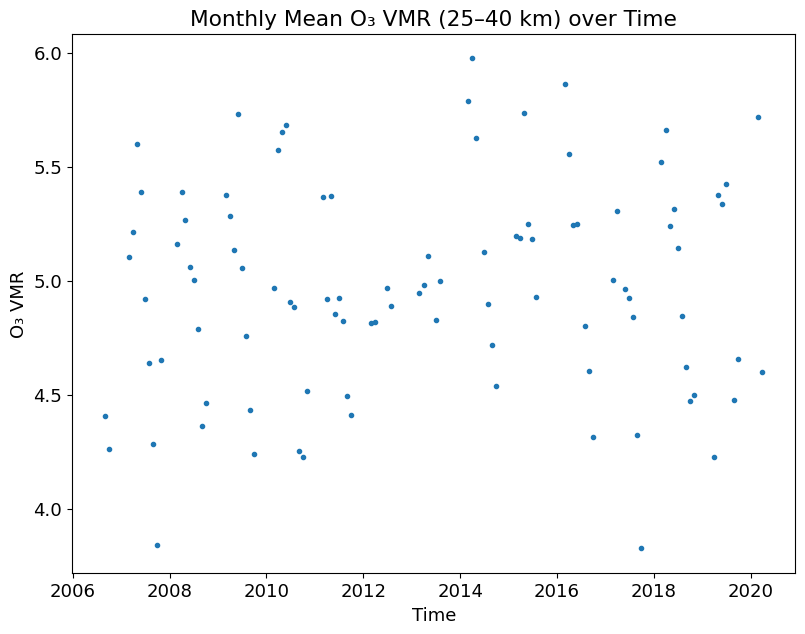

In [41]:
(O3_times.sel(altitude1 = slice(25, 40)).resample(DATETIME = "1M").mean(dim = ["altitude1", "DATETIME"]) * 10**6).plot(marker = ".", linestyle = "None", size = 7)

plt.ylabel("O₃ VMR")
plt.xlabel("Time")
plt.title("Monthly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

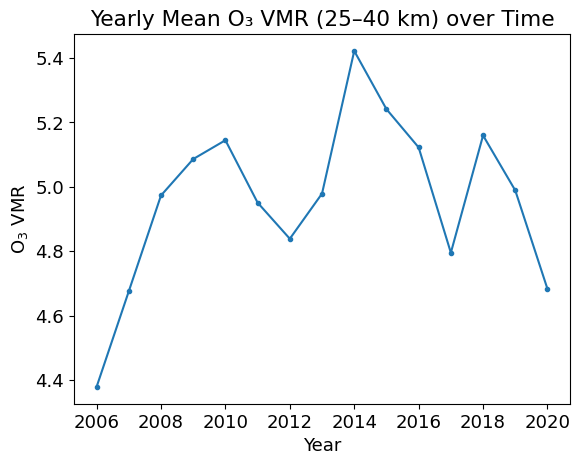

In [42]:
has_fig = (O3_times.sel(altitude1 = slice(25, 40)).groupby("DATETIME.year").mean(dim = ["altitude1", "DATETIME"]) * 10**6).plot(marker = ".")
plt.xlabel("Year")
plt.ylabel("O$_3$ VMR")
plt.title("Yearly Mean O₃ VMR (25–40 km) over Time")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")